#Analyze Spotify Track Data
##In this notebook, I'll be exploring the data we scraped and cleaned in previous steps. I made some data changes based on early exploration of track features and ran the data through several ML models to try to find the most accurate way of predicting a track's popularity.

## Initialize data and see what we're working with

In [ ]:
# uploaded = files.upload()
# import os
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/spotify-f1cf5-firebase-adminsdk-xxrd4-763e07c601.json'
# import firebase_admin
# from firebase_admin import credentials
# from google.cloud import firestore

In [ ]:
# cred = credentials.Certificate('/content/spotify-f1cf5-firebase.json')
# firebase_admin.initialize_app(cred, {
#     'databaseURL': 'https://spotify-f1cf5.firebaseio.com'
# })

# db = firestore.Client()

# tracks_ref = db.collection(u'tracks')
# tracks = tracks_ref.stream()

# track_list = []
# for track in tracks:
#   track_list.append(track.to_dict())
# track_table = pd.DataFrame(track_list)

In [3]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()

Saving cleaned_tracks_both.csv to cleaned_tracks_both.csv


In [4]:
track_table = pd.read_csv("cleaned_tracks_both.csv")

In [3]:
track_table.head()

,track_pop,track_name,track_id,track_year,track_spotify_genre,art_name,art_id,alb_name,alb_id,art_genre,duration_ms,time_signature,key,loudness,energy,speechiness,acousticness,mode,tempo,valence,danceability,instrumentalness,liveness,genre_words,master_popular_genre
0,50,"Turandot / Act 3: Turandot / Act 3: ""Nessun do...",1GqszY8D6qlMHY7KmA5wE8,2011,classical,Andrea Bocelli,3EA9hVIzKfFiQI0Kikz2wo,Concerto: One Night In Central Park (Remastered),7LkXjMXDhwqXl3l9zqxRRz,"['classical tenor', 'italian tenor', 'operatic...",247010,4,2,-9.841,0.41200,0.0357,0.94300,1,88.113,0.193,0.167,0.000121,0.7570,"{'classical': 1, 'tenor': 2, 'italian': 1, 'op...",pop
1,44,Bad Asteroid,5TzCDKy1ZmFZdW8100A8p9,2011,classical,The Aristocrats,1V4jsLjkic1Mxvdke86Qth,The Aristocrats,7GKzcJbW0Qernh0Xab1bIf,"['instrumental rock', 'jazz fusion', 'neo clas...",353667,4,11,-7.257,0.72700,0.0462,0.03010,0,87.349,0.391,0.485,0.758000,0.1630,"{'instrumental': 1, 'rock': 1, 'jazz': 2, 'fus...",rock
2,37,The Whispers,4VH3rKj1tmhUZtX3U43jBq,2011,classical,Harold Budd,3uOCouLFR4bVx0XeiQJSbl,In The Mist,3J8bwfrUYrzmuE0IqFLhUS,"['ambient', 'american contemporary classical',...",163000,3,9,-35.213,0.00385,0.0449,0.99500,0,141.201,0.117,0.228,0.917000,0.0858,"{'ambient': 2, 'american': 1, 'contemporary': ...",rock
3,41,"Time To Say Goodbye - Live At Central Park, Ne...",1Jw2mwSScPEROBomYw6L0g,2011,classical,Andrea Bocelli,3EA9hVIzKfFiQI0Kikz2wo,Concerto: One Night In Central Park (Remastered),7LkXjMXDhwqXl3l9zqxRRz,"['classical tenor', 'italian tenor', 'operatic...",253991,3,7,-9.827,0.30500,0.0318,0.93600,1,85.786,0.446,0.230,0.000002,0.7440,"{'classical': 1, 'tenor': 2, 'italian': 1, 'op...",pop
4,42,Anthem,0ZUPWnw89a0iLfNdcUiIm3,2011,classical,Iced Earth,3KEixcRfBS5K3E91Vn1Kdy,Dystopia,6la9AnaFIgSo4faEDcnHQx,"['hard rock', 'melodic metal', 'metal', 'neo c...",294613,4,3,-5.242,0.95400,0.0607,0.00894,0,163.995,0.287,0.454,0.000000,0.0659,"{'hard': 1, 'rock': 1, 'melodic': 1, 'metal': ...",rock


##Explore Numeric Variables
In this section, I'll be selecting just the numeric columns in our data and exploring their distributions, correlations, and more.

In [19]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
track_table_numerics = track_table.select_dtypes(include=[np.number])

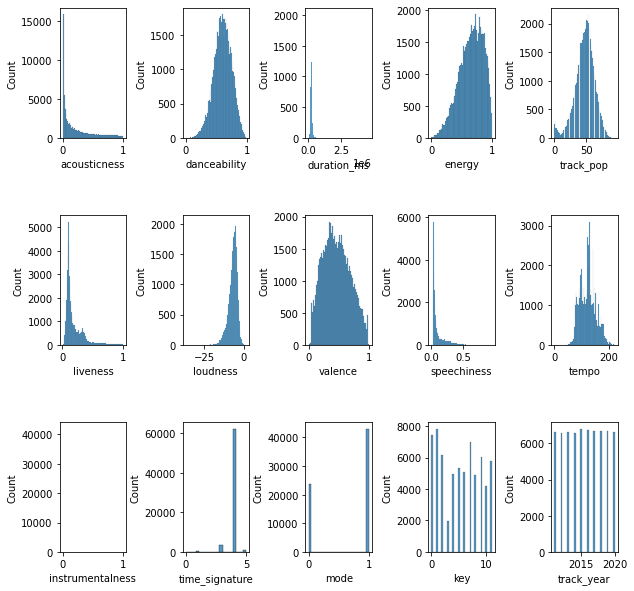

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
 
f, axes = plt.subplots(3, 5, figsize=(10, 10))
plt.subplots_adjust(wspace=.85, hspace=.6)
sns.histplot( track_table_numerics["acousticness"] , ax=axes[0, 0])
sns.histplot( track_table_numerics["danceability"] , ax=axes[0, 1])
sns.histplot( track_table_numerics["duration_ms"] , ax=axes[0, 2])
sns.histplot( track_table_numerics["energy"] , ax=axes[0, 3])
sns.histplot( track_table_numerics["track_pop"] , ax=axes[0, 4])
sns.histplot( track_table_numerics["liveness"] , ax=axes[1, 0])
sns.histplot( track_table_numerics["loudness"] , ax=axes[1, 1])
sns.histplot( track_table_numerics["valence"] , ax=axes[1, 2])
sns.histplot( track_table_numerics["speechiness"] , ax=axes[1, 3])
sns.histplot( track_table_numerics["tempo"] , ax=axes[1, 4])
sns.histplot( track_table_numerics["instrumentalness"] , ax=axes[2, 0])
sns.histplot( track_table_numerics["time_signature"] , ax=axes[2, 1])
sns.histplot( track_table_numerics["mode"] , ax=axes[2, 2])
sns.histplot( track_table_numerics["key"] , ax=axes[2, 3])
sns.histplot( track_table_numerics["track_year"] , ax=axes[2, 4])

I was pleased to see that our outcome variable, Track Popularity, had a mostly normal distribution. Since we were pulling tracks from Spotify based on simple queries, I was a bit concerned it would overselect songs with high popularity,  but this doesn't seem to be the case. The only non-normal feature of this histogram is the small spike at popularity 0.

Text(0.5, 1.0, 'Track Popularity')

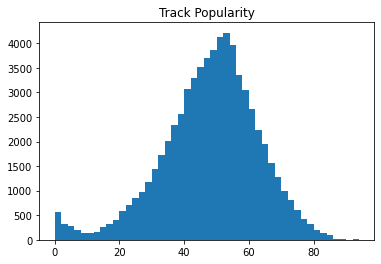

In [21]:
import matplotlib.pyplot as plt
plt.hist(track_table_numerics["track_pop"], bins=47)  #Chose 47 because it results in bins of size 2 (0-2,2-4, etc)
plt.title("Track Popularity")

Next, I wanted to see if there were any variables with extremely high correlations.

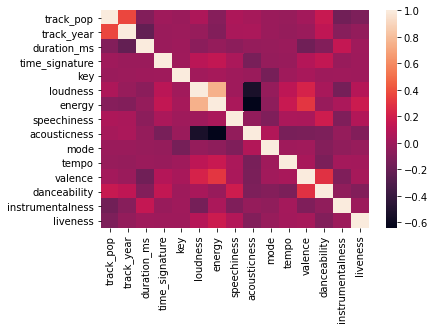

In [7]:
sns.heatmap(track_table_numerics.corr())

Based on this heatmap, I determined that loudness and energy were clearly highly correlative, so I chose to drop energy, as this also had a high negative correlation with acousticness.

In [10]:
print("Energy/Loudness correlation:", np.corrcoef(track_table_numerics.energy, track_table_numerics.loudness))
print("Loudness/Accousticness correlation:", np.corrcoef(track_table_numerics.loudness, track_table_numerics.acousticness))
print("Energy/Accousticness correlation:", np.corrcoef(track_table_numerics.energy, track_table_numerics.acousticness))

Energy/Loudness correlation: [[1.         0.75027295]
 [0.75027295 1.        ]]
Loudness/Accousticness correlation: [[ 1.         -0.53300453]
 [-0.53300453  1.        ]]
Energy/Accousticness correlation: [[ 1.         -0.64270152]
 [-0.64270152  1.        ]]


I then converted my categorical variables mode, key, time_signature, and both genres to dummies. I dropped columns like the artist name, album name, original genre list, and more. I did this because each of these had so many possible values in the dataset that it was completely impractical to create dummies for each of these values. I also felt that it would be a bit unfair to include things like artist name, as this would likely be hugely predictive in determining the track's popularity and would defeat the purpose of analysing the audible qualities.

In [38]:
track_table_dummies = pd.get_dummies(track_table,columns=['mode','key','time_signature','track_spotify_genre','master_popular_genre'],drop_first=True)
#track_table_dummies = pd.get_dummies(track_table,columns=['mode','time_signature','track_spotify_genre','master_popular_genre'],drop_first=True)

track_table_dummies.drop(['energy'], axis=1, inplace=True)
track_table_dummies = track_table_dummies.select_dtypes(include=[np.number])
track_table_dummies.dropna(inplace=True)


At this point, I was confident in my dataset and wanted to start trying to predict the target variable track_pop.

In [12]:
track_table.tail(10)

,track_pop,track_name,track_id,track_year,track_spotify_genre,art_name,art_id,alb_name,alb_id,art_genre,duration_ms,time_signature,key,loudness,energy,speechiness,acousticness,mode,tempo,valence,danceability,instrumentalness,liveness,genre_words,master_popular_genre
0,50,"Turandot / Act 3: Turandot / Act 3: ""Nessun do...",1GqszY8D6qlMHY7KmA5wE8,2011,classical,Andrea Bocelli,3EA9hVIzKfFiQI0Kikz2wo,Concerto: One Night In Central Park (Remastered),7LkXjMXDhwqXl3l9zqxRRz,"['classical tenor', 'italian tenor', 'operatic...",247010,4,2,-9.841,0.41200,0.0357,0.94300,1,88.113,0.193,0.167,0.000121,0.7570,"{'classical': 1, 'tenor': 2, 'italian': 1, 'op...",pop
1,44,Bad Asteroid,5TzCDKy1ZmFZdW8100A8p9,2011,classical,The Aristocrats,1V4jsLjkic1Mxvdke86Qth,The Aristocrats,7GKzcJbW0Qernh0Xab1bIf,"['instrumental rock', 'jazz fusion', 'neo clas...",353667,4,11,-7.257,0.72700,0.0462,0.03010,0,87.349,0.391,0.485,0.758000,0.1630,"{'instrumental': 1, 'rock': 1, 'jazz': 2, 'fus...",rock
2,37,The Whispers,4VH3rKj1tmhUZtX3U43jBq,2011,classical,Harold Budd,3uOCouLFR4bVx0XeiQJSbl,In The Mist,3J8bwfrUYrzmuE0IqFLhUS,"['ambient', 'american contemporary classical',...",163000,3,9,-35.213,0.00385,0.0449,0.99500,0,141.201,0.117,0.228,0.917000,0.0858,"{'ambient': 2, 'american': 1, 'contemporary': ...",rock
3,41,"Time To Say Goodbye - Live At Central Park, Ne...",1Jw2mwSScPEROBomYw6L0g,2011,classical,Andrea Bocelli,3EA9hVIzKfFiQI0Kikz2wo,Concerto: One Night In Central Park (Remastered),7LkXjMXDhwqXl3l9zqxRRz,"['classical tenor', 'italian tenor', 'operatic...",253991,3,7,-9.827,0.30500,0.0318,0.93600,1,85.786,0.446,0.230,0.000002,0.7440,"{'classical': 1, 'tenor': 2, 'italian': 1, 'op...",pop
4,42,Anthem,0ZUPWnw89a0iLfNdcUiIm3,2011,classical,Iced Earth,3KEixcRfBS5K3E91Vn1Kdy,Dystopia,6la9AnaFIgSo4faEDcnHQx,"['hard rock', 'melodic metal', 'metal', 'neo c...",294613,4,3,-5.242,0.95400,0.0607,0.00894,0,163.995,0.287,0.454,0.000000,0.0659,"{'hard': 1, 'rock': 1, 'melodic': 1, 'metal': ...",rock


##Creating and Tuning Models

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import linear_model

I started by splitting the dataset into a training set (67%) and a test set (33%).

In [39]:
X = track_table_dummies.iloc[:,1:]
y = track_table_dummies.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

I created a small helper method to print out model statistics / results.

In [13]:
def print_score(modelName, grid):
  print(modelName)
  print("The best score is {}".format(grid.best_score_))
  print("The best hyper parameter setting is {}".format(grid.best_params_))
  mae = mean_absolute_error(y_test, grid.predict(X_test))
  print("Test mean absolute error:", mae)
  mse = mean_squared_error(y_test,grid.predict(X_test))
  print("Test mean-squared error:", mse)
  rmse = np.sqrt(mse)
  print("Test root mean squared error:", np.sqrt(mse))
  return [modelName, mae, rmse]

## Linear Models
### Simple linear regression
I started by performing a simple multivariate linear regression, as this basic model would serve as a baseline for what to expect for our more complex models.

In [27]:
model = sm.OLS(y_train,X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              track_pop   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                          1.475e+04
Date:                Tue, 15 Jun 2021   Prob (F-statistic):                        0.00
Time:                        07:11:13   Log-Likelihood:                     -1.7929e+05
No. Observations:               44678   AIC:                                  3.587e+05
Df Residuals:                   44639   BIC:                                  3.590e+05
Df Model:                          39                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
track_year                      0.0489      0.003     14.806      0.000       0.042       0.055
duration_ms                 -7.258e-06   9.28e-07     -7.823      0.000   -9.08e-06   -5.44e-06
loudness                        0.4966      0.028     17.862      0.000       0.442       0.551
speechiness                     1.7271      0.746      2.314      0.021       0.264       3.190
acousticness                    5.1878      0.302     17.197      0.000       4.597       5.779
tempo                           0.0008      0.002      0.361      0.718      -0.004       0.005
valence                        -3.5675      0.322    -11.090      0.000      -4.198      -2.937
danceability                   17.5364      0.539     32.555      0.000      16.481      18.592
instrumentalness               -9.8620      0.346    -28.528      0.000     -10.540      -9.184
liveness                      -10.4296      0.412    -25.326      0.000     -11.237      -9.622
mode_1                         -0.3075      0.142     -2.163      0.031      -0.586      -0.029
key_1                          -0.0540      0.267     -0.203      0.839      -0.577       0.469
key_2                          -0.4519      0.281     -1.606      0.108      -1.003       0.100
key_3                           0.7739      0.410      1.887      0.059      -0.030       1.578
key_4                          -0.3939      0.304     -1.296      0.195      -0.990       0.202
key_5                           0.8387      0.296      2.833      0.005       0.259       1.419
key_6                           0.0367      0.300      0.123      0.902      -0.551       0.624
key_7                          -0.3977      0.273     -1.456      0.145      -0.933       0.138
key_8                           0.4151      0.301      1.378      0.168      -0.175       1.006
key_9                          -1.0577      0.283     -3.733      0.000      -1.613      -0.502
key_10                          0.2087      0.319      0.655      0.512      -0.416       0.833
key_11                         -0.2323      0.293     -0.794      0.427      -0.806       0.341
time_signature_1              -61.3608      6.713     -9.141      0.000     -74.518     -48.204
time_signature_3              -61.1911      6.649     -9.203      0.000     -74.223     -48.159
time_signature_4              -61.8123      6.645     -9.303      0.000     -74.836     -48.789
time_signature_5              -61.3730      6.667     -9.205      0.000     -74.441     -48.305
track_spotify_genre_country     2.5872      0.734      3.526      0.000       1.149       4.025
track_spotify_genre_hip-hop     8.4786      0.735     11.543      0.000       7.039       9.918
track_sp

In [16]:
print("Linear Regression:")
print("Test mean absolute error:", mean_absolute_error(y_test, results.predict(X_test)))
lr_mse = mean_squared_error(y_test,results.predict(X_test))
print("Test mean-squared error:", lr_mse)
print("Test root mean squared error:", np.sqrt(lr_mse))

Linear Regression:
Test mean absolute error: 10.029822469860644
Test mean-squared error: 178.29099249548347
Test root mean squared error: 13.35256501558721


The linear regression provided a few interesting insights. 

Firstly, our baseline MAE will be about 10, meaning that the popularity predictions of a simple linear regression are off by about 10 popularity per prediction (scale is 1-100).

Secondly, our linear regression model has quite a high R-squared at .928, suggesting that almost 93% of the variation in popularity can be determined by the variables in the model. This is promising and a lot higher than I expected.

The regression also showed that a large number of our variables are significant, with most of the p-values falling below .05. One set of features, though, that did not seem very useful was *tempo* with a p-value of 0.718 and a coefficient of 0.0008. 

I chose to drop this from the dataset, re-partition the training and test set, and see how it affected the Linear Regression model. I'm hoping for and expecting little drop in the R-Squared.

In [40]:
track_table_dummies.drop(['tempo'], axis=1, inplace=True)
X = track_table_dummies.iloc[:,1:]
y = track_table_dummies.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [42]:
model = sm.OLS(y_train,X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              track_pop   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                          1.514e+04
Date:                Tue, 15 Jun 2021   Prob (F-statistic):                        0.00
Time:                        07:24:13   Log-Likelihood:                     -1.7929e+05
No. Observations:               44678   AIC:                                  3.586e+05
Df Residuals:                   44640   BIC:                                  3.590e+05
Df Model:                          38                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
track_year                      0.0489      0.003     14.807      0.000       0.042       0.055
duration_ms                 -7.264e-06   9.28e-07     -7.831      0.000   -9.08e-06   -5.45e-06
loudness                        0.4970      0.028     17.890      0.000       0.443       0.551
speechiness                     1.7504      0.744      2.354      0.019       0.293       3.208
acousticness                    5.1783      0.301     17.232      0.000       4.589       5.767
valence                        -3.5605      0.321    -11.089      0.000      -4.190      -2.931
danceability                   17.5053      0.532     32.922      0.000      16.463      18.548
instrumentalness               -9.8580      0.346    -28.532      0.000     -10.535      -9.181
liveness                      -10.4336      0.412    -25.345      0.000     -11.240      -9.627
mode_1                         -0.3071      0.142     -2.160      0.031      -0.586      -0.028
key_1                          -0.0540      0.267     -0.203      0.840      -0.577       0.469
key_2                          -0.4518      0.281     -1.606      0.108      -1.003       0.100
key_3                           0.7733      0.410      1.885      0.059      -0.031       1.577
key_4                          -0.3936      0.304     -1.295      0.195      -0.989       0.202
key_5                           0.8388      0.296      2.834      0.005       0.259       1.419
key_6                           0.0359      0.300      0.120      0.905      -0.551       0.623
key_7                          -0.3982      0.273     -1.458      0.145      -0.933       0.137
key_8                           0.4159      0.301      1.381      0.167      -0.175       1.006
key_9                          -1.0579      0.283     -3.733      0.000      -1.613      -0.502
key_10                          0.2091      0.319      0.656      0.512      -0.415       0.833
key_11                         -0.2321      0.293     -0.793      0.427      -0.805       0.341
time_signature_1              -61.2638      6.707     -9.134      0.000     -74.410     -48.118
time_signature_3              -61.0743      6.641     -9.197      0.000     -74.091     -48.058
time_signature_4              -61.7025      6.638     -9.296      0.000     -74.712     -48.693
time_signature_5              -61.2699      6.661     -9.198      0.000     -74.326     -48.214
track_spotify_genre_country     2.5938      0.733      3.537      0.000       1.156       4.031
track_spotify_genre_hip-hop     8.4841      0.734     11.553      0.000       7.045       9.923
track_spotify_genre_house       8.9258      0.726     12.290      0.000       7.502      10.349
track_sp

As expected, no change in the R-squared. The only other variables I considered dropping were key and master_popular_genre because several of the categories for these features are insignificant. However, since I would also have to drop the significant categories if I wanted to drop the insignificant ones, I chose to leave them in.

In [30]:
print("Linear Regression:")
lr_mae = mean_absolute_error(y_test, results.predict(X_test))
print("Test mean absolute error:", mean_absolute_error(y_test, results.predict(X_test)))
lr_mse = mean_squared_error(y_test,results.predict(X_test))
print("Test mean-squared error:", lr_mse)
lr_rmse = np.sqrt(lr_mse)
print("Test root mean squared error:", np.sqrt(lr_mse))
lr_stats = ["Linear Regression", lr_mae, lr_rmse ]

Linear Regression:
Test mean absolute error: 10.029911884302587
Test mean-squared error: 178.2921427513868
Test root mean squared error: 13.35260808798741


### Regularized Linear Models
I also tried a Ridge regression and a Lasso regression to check out how regularization would improve the linear model. For both of these regressions, I varied the regularization strength to see what alpha performed the best:

In [24]:
alphas = np.array([1, 0.5, .01, 0.05, .001, 0.005, 0.001, 0.0005])
ridge_grid = GridSearchCV(estimator=linear_model.Ridge(), param_grid=dict(alpha=alphas), cv=3)
ridge_grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 5.e-01, 1.e-02, 5.e-02, 1.e-03, 5.e-03, 1.e-03, 5.e-04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [74]:
ridge_stats = print_score("Ridge Regression",ridge_grid)

Ridge Regression
The best score is 0.29565428158944934
The best hyper parameter setting is {'alpha': 1.0}
Test mean absolute error: 8.96323766730061
Test mean-squared error: 156.80695750657955
Test root mean squared error: 12.522258482661167


In [26]:
alphas = np.array([1, 0.5, .01, 0.05, .001, 0.005, 0.001, 0.0005])
lasso_grid = GridSearchCV(estimator=linear_model.Lasso(), param_grid=dict(alpha=alphas), cv=3)
lasso_grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 5.e-01, 1.e-02, 5.e-02, 1.e-03, 5.e-03, 1.e-03, 5.e-04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [82]:
lasso_stats = print_score("Lasso Regression",lasso_grid)

Lasso Regression
The best score is 0.2957197876221089
The best hyper parameter setting is {'alpha': 0.001}
Test mean absolute error: 8.964674773868138
Test mean-squared error: 156.8194017031554
Test root mean squared error: 12.522755355877372


These models performed a bit better, suggesting that the original linear model was overfitting a bit. We'll see if we can improve over this 9 MSE using more complex ML Models below.

##Machine Learning Models
For each of these models, I used GridSearchCV to try a number of hyperparameters that could potentially improve performance of each of the models.

I tried a Decision Tree, Random Forest, Gradient Boost, Ada Boost, XG Boost, and Neural Network. At the end, I summarized all of the models' performances.

I waited to scale the data until this point, as I wanted to be able to directly interpret the coefficients of the linear regression. While not all of the below Machine Learning models require scaling, it will speed up at least the neural network's performance, so why not.

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

track_table_dummies[track_table_dummies.columns] = scaler.fit_transform(track_table_dummies[track_table_dummies.columns])
X = track_table_dummies.iloc[:,1:]
y = track_table_dummies.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train

####Decision Tree

In [ ]:
dt_param_grid = {
              'max_depth':range(1,16),
              #'max_depth': 9,
              'min_samples_split':range(2,20)#,
              #'min_samples_split': 8
}
dt_grid = GridSearchCV(DecisionTreeRegressor(), dt_param_grid, cv=3, verbose=2).fit(X_train, y_train)
# summarize the results of the grid search

In [76]:
dt_stats = print_score('Decision Tree', dt_grid)

Decision Tree
The best score is 0.4236098809968887
The best hyper parameter setting is {'max_depth': 10, 'min_samples_split': 17}
Test mean absolute error: 8.051317515301367
Test mean-squared error: 129.3120016105052
Test root mean squared error: 11.371543501675804


###Random Forest

In [33]:
rf_param_grid = {#'bootstrap': [True, False],
                 'bootstrap': [True],
              #'n_estimators':range(50,400, 50),
              'n_estimators': 250
              #'max_depth':range(3,12, 2),
              'max_depth': 11
              #'min_samples_split': [2,3,4]
              'min_samples_split': 4
}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv=3).fit(X_train, y_train)
# summarize the results of the grid search

In [75]:
rf_stats = print_score('Random Forest', rf_grid)

Random Forest
The best score is 0.5057538748354612
The best hyper parameter setting is {'bootstrap': True, 'max_depth': 11, 'min_samples_split': 4, 'n_estimators': 250}
Test mean absolute error: 7.625212497196012
Test mean-squared error: 110.41720691864234
Test root mean squared error: 10.507959217595124


### Gradient Boost

In [41]:
gb_param_grid = {
     #'learning_rate': [.01,.1,1],
     'learning_rate':[.1],
     #'max_depth': range(8,16,2),
     'max_depth':[14],
     #'n_estimators': range(250,400,50),
     'n_estimators':[350],
     #'min_samples_split': [0.01, 0.05, 0.1]
     'min_samples_split':[.01] 
}

gb_grid = GridSearchCV(GradientBoostingRegressor(), gb_param_grid, cv=3, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=14, min_samples_split=0.01, n_estimators=350 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=14, min_samples_split=0.01, n_estimators=350, total= 2.1min
[CV] learning_rate=0.1, max_depth=14, min_samples_split=0.01, n_estimators=350 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=14, min_samples_split=0.01, n_estimators=350, total= 2.1min
[CV] learning_rate=0.1, max_depth=14, min_samples_split=0.01, n_estimators=350 
[CV]  learning_rate=0.1, max_depth=14, min_samples_split=0.01, n_estimators=350, total= 2.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.2min finished


In [47]:
gb_stats = print_score('Gradient Boost', gb_grid)

Gradient Boost
The best score is 0.5356951848210351
The best hyper parameter setting is {'learning_rate': 0.1, 'max_depth': 14, 'min_samples_split': 0.01, 'n_estimators': 350}
Test mean absolute error: 7.5000444778252096
Test mean-squared error: 101.70676061507417
Test root mean squared error: 10.084976976427571


### ADA Boost

In [41]:
ab_param_grid = {
  'n_estimators': range(50,500,50),
  'learning_rate' : [0.01,0.05,0.1,0.3,1],
  'loss' : ['linear', 'square', 'exponential']
}

ab_grid = GridSearchCV(AdaBoostRegressor(), ab_param_grid, cv=3, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] learning_rate=0.01, loss=linear, n_estimators=50 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . learning_rate=0.01, loss=linear, n_estimators=50, total=   5.5s
[CV] learning_rate=0.01, loss=linear, n_estimators=50 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] . learning_rate=0.01, loss=linear, n_estimators=50, total=   5.5s
[CV] learning_rate=0.01, loss=linear, n_estimators=50 ................
[CV] . learning_rate=0.01, loss=linear, n_estimators=50, total=   5.5s
[CV] learning_rate=0.01, loss=linear, n_estimators=70 ................
[CV] . learning_rate=0.01, loss=linear, n_estimators=70, total=   7.6s
[CV] learning_rate=0.01, loss=linear, n_estimators=70 ................
[CV] . learning_rate=0.01, loss=linear, n_estimators=70, total=   7.6s
[CV] learning_rate=0.01, loss=linear, n_estimators=70 ................
[CV] . learning_rate=0.01, loss=linear, n_estimators=70, total=   7.6s
[CV] learning_rate=0.01, loss=linear, n_estimators=90 ................
[CV] . learning_rate=0.01, loss=linear, n_estimators=90, total=   9.7s
[CV] learning_rate=0.01, loss=linear, n_estimators=90 ................
[CV] . learning_rate=0.01, loss=linear, n_estimators=90, total=   9.7s
[CV] learning_rate=0.01, loss=linear, n_estimators=90 ................
[CV] .

[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed: 30.3min finished


In [78]:
ab_stats = print_score('Ada Boost', ab_grid)

Ada Boost
The best score is 0.2629483400211395
The best hyper parameter setting is {'learning_rate': 0.05, 'loss': 'exponential', 'n_estimators': 110}
Test mean absolute error: 9.691451110053967
Test mean-squared error: 164.46199346385464
Test root mean squared error: 12.824273603750608


### XG Boost

In [45]:
xg_param_grid = {
    'clf__n_estimators': range(50,500,50),
    #'clf__n_estimators': [50],
    #'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__learning_rate': [0.01],
    'clf__max_depth': range(3,20,5),
    #'clf__max_depth': [3],
    'fs__score_func': ["chi2"],
    'fs__k': [10],
    'objective':['reg:squarederror']
}

xg_grid = GridSearchCV(XGBRegressor(), xg_param_grid, cv=3, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__learning_rate=0.01, clf__max_depth=3, clf__n_estimators=50, fs__k=10, fs__score_func=chi2, objective=reg:squarederror 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__learning_rate=0.01, clf__max_depth=3, clf__n_estimators=50, fs__k=10, fs__score_func=chi2, objective=reg:squarederror, total=   3.6s
[CV] clf__learning_rate=0.01, clf__max_depth=3, clf__n_estimators=50, fs__k=10, fs__score_func=chi2, objective=reg:squarederror 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  clf__learning_rate=0.01, clf__max_depth=3, clf__n_estimators=50, fs__k=10, fs__score_func=chi2, objective=reg:squarederror, total=   3.4s
[CV] clf__learning_rate=0.01, clf__max_depth=3, clf__n_estimators=50, fs__k=10, fs__score_func=chi2, objective=reg:squarederror 
[CV]  clf__learning_rate=0.01, clf__max_depth=3, clf__n_estimators=50, fs__k=10, fs__score_func=chi2, objective=reg:squarederror, total=   3.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.4s finished


In [79]:
xg_stats = print_score('XG Boost', xg_grid)

XG Boost
The best score is 0.4638104679923631
The best hyper parameter setting is {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 50, 'fs__k': 10, 'fs__score_func': 'chi2', 'objective': 'reg:squarederror'}
Test mean absolute error: 7.997105604435632
Test mean-squared error: 121.06921959651262
Test root mean squared error: 11.003145895447929


### Neural Network

In [47]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [49]:
nn_param_grid = {
     'activation': ['identity', 'logistic', 'tanh', 'relu'],
     #'activation': ['logistic'],
     'learning_rate': ['constant','adaptive'],
     #'learning_rate':[ 'adaptive'],
     'learning_rate_init': [0.00005,0.0005,.001,.01],
     #'learning_rate_init': [0.01],
     'hidden_layer_sizes': [3,5,10,50,100]
     #'hidden_layer_sizes': [10]
}

nn_grid = GridSearchCV(MLPRegressor(), nn_param_grid, cv=3).fit(X_train, y_train)

In [80]:
nn_stats = print_score('Neural Network', nn_grid)

Neural Network
The best score is -0.005899028188602958
The best hyper parameter setting is {'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 400}
Test mean absolute error: 11.397430986073669
Test mean-squared error: 218.44984836940577
Test root mean squared error: 14.780048997530615


##Model Comparisons
Let's take a look at how each metric compared in performance.

In [97]:
scores_df = pd.DataFrame(data = [lr_stats,ridge_stats, lasso_stats, dt_stats, rf_stats, gb_stats, ab_stats, xg_stats, nn_stats],
                         columns = ["Model Name", "Mean Absolute Error", "Root Mean Squared Error"])
scores_df = scores_df.sort_values(by="Mean Absolute Error").reset_index(drop=True)

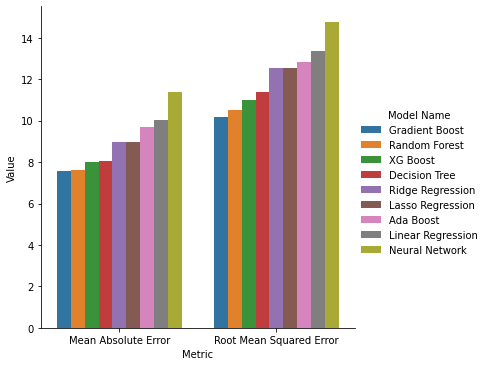

In [98]:
melted_scores = pd.melt(scores_df, id_vars = "Model Name", var_name = "Metric", value_name="Value")
sns.catplot(x="Metric", y="Value",hue="Model Name", data = melted_scores, kind="bar")

Some interesting takeaways here:
Gradient Boost performed the best, simple linear regression performed the worst. This is fairly expected, as boosting methods are popular for their accuracy, and the linear model underforms due to its high bias / over simplicity.

Neural networks severely underperformed here. This could be for a number of reasons:
- Not enough training data
- Improper tuning of hyperparameters

Final error results for the best performing model:

In [50]:
print_score("Gradient Boost",gb_grid)

Gradient Boost
The best score is 0.5356951848210351
The best hyper parameter setting is {'learning_rate': 0.1, 'max_depth': 14, 'min_samples_split': 0.01, 'n_estimators': 350}
Test mean absolute error: 7.5000444778252096
Test mean-squared error: 101.70676061507417
Test root mean squared error: 10.084976976427571


['Gradient Boost', 7.5000444778252096, 10.084976976427571]

## Visualizing Error of Best Model
In this section, I'll break down how the gradient boost regressor that we trained performs, analyzing where most of its error came from.

First, let's just take a basic look at the distribution of the error:

Text(0.5, 1.0, 'Error Histogram')

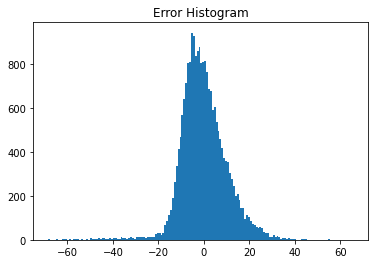

In [46]:
plt.hist(y_test - gb_grid.predict(X_test), bins='auto')  # arguments are passed to np.histogram
plt.title("Error Histogram")

This is a pretty normal error curve.

This biggest takeaway here is that it seems like the gradient boost regressor is missing badly on some tracks with high negative error, suggesting that the model is overpredicting the popularity severely of some tracks. Other than that, not a ton to take away here.

Now to look at the error results relative to the true popularity values:

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>


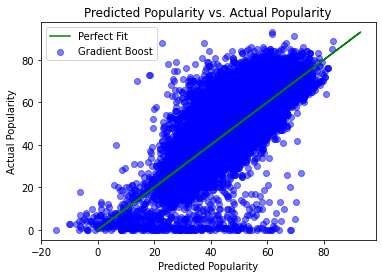

<Figure size 864x576 with 0 Axes>

In [43]:
gb_pred = gb_grid.predict(X_test)
plt.scatter(x=gb_pred, y=y_test, alpha=.5, color = 'b', label = "Gradient Boost")
#plt.scatter(x=ada_pred, y=test_y, alpha=.5, color = 'r', label = "Ada Boost")
plt.plot(y_test, y_test, color = 'g', label = 'Perfect Fit')
plt.xlabel('Predicted Popularity')
plt.ylabel('Actual Popularity')
plt.legend(loc='upper left')
plt.title("Predicted Popularity vs. Actual Popularity")
plt.figure(figsize=(12,8))
print(plt)

The above plot shows where our model is successfully predicting near the actual popularity and where it's failing. It seems that our model mostly struggles with songs that have low actual popularity, as visualized by the mass of blue dots around Actual Popularity = 0, even as predicted popularity increased. It seemed that the model actually performed surprisingly well as Actual Popularity increased, though.

Let's compare this to the Linear Regression, the simplest model.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>


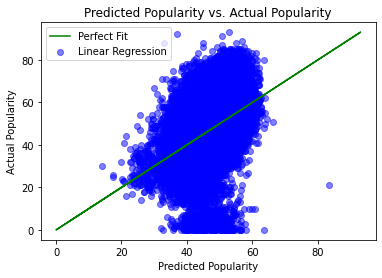

<Figure size 1728x1152 with 0 Axes>

In [44]:
reg_pred = results.predict(X_test)
plt.scatter(x=reg_pred, y=y_test, alpha=.5, color = 'b', label = "Linear Regression")
#plt.scatter(x=ada_pred, y=test_y, alpha=.5, color = 'r', label = "Ada Boost")
plt.plot(y_test, y_test, color = 'g', label = 'Perfect Fit')
plt.xlabel('Predicted Popularity')
plt.ylabel('Actual Popularity')
plt.legend(loc='upper left')
plt.title("Predicted Popularity vs. Actual Popularity")
plt.figure(figsize=(24,16))
print(plt)

Looks like the linear model just predicted every song had a popularity of between 20-60. This is an example of how low-bias models can yield a fairly reasonable error but fail to capture any nuance of the data. This certainly makes the gradient boost look better.

Let's look at both of these on the same chart:

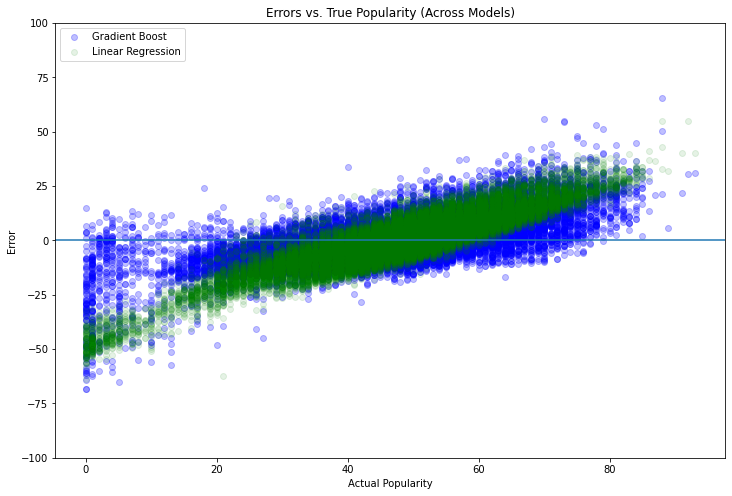

In [45]:
plt.figure(figsize=(12,8))
plt.scatter(y_test,y_test - gb_grid.predict(X_test),color='b', alpha = .25, label = 'Gradient Boost')
plt.scatter(y_test,y_test - results.predict(X_test),color='g', alpha = .1, label = 'Linear Regression')
#plt.scatter(test_outcome,test_outcome - knn_grid.predict(test_features),color='g', alpha = .5, label = 'Random Forests')
plt.axhline(y = 0)
plt.ylim(-100, 100)
plt.xlabel('Actual Popularity')
plt.ylabel('Error')
plt.title("Errors vs. True Popularity (Across Models)")
plt.legend(loc='upper left')
plt.show()

This plot is a bit cluttered, but it gives us a better idea of where our model is failing and how it compares to the simple linear regression. It seems that both the gradient boost and the linear regression are severely **overpredicting** the popularity of songs with low true-popularity, as exemplified by the large number of points near the 0-20 actual popularity range (negative error results from an overprediction of the true value). Conversely, there are a large number of points at the high actual popularity range (70-85) where our model is underpredicting (positive error value). 

This pattern on either end of the actual popularity makes some sense - we're of course not underpredicting true-popularity points of 0, as this would involve the model predicting a negative value. The same goes for the top end, as our highest prediction of our model is only around 85, so it's never missing over the top.

However, one area of focus in improving this model would be the low-end of the popularity range, as this is where the regressor is most off.

### Error Across Genre
Finally, lets take a look at error across song genre - was the model better at predicting popularity of some musical genres over others?3

I'll represent this with a violin plot - the width of each violin represents the count of predictions at that error value, so the Error value at the fattest part of the violin represents the amount of error that occurs for our predictions of that genre most often. The height of the violin, or how much it looks like its stretching, represents the range of error for that genre. 

In [93]:
tracks_clean = pd.read_csv('cleaned_tracks_both.csv')
genres = pd.DataFrame(tracks_clean["track_spotify_genre"])

# get errors for the neural network
gb_errors =  pd.DataFrame(y_test - gb_grid.predict(X_test))
gb_errors.rename({"track_pop": "error"}, axis='columns', inplace=True)

# overwrite indexes because this is horrible
gb_errors.index = gb_errors.index.astype(str)
genres.index = genres.index.astype(str)

res = gb_errors.join(genres)


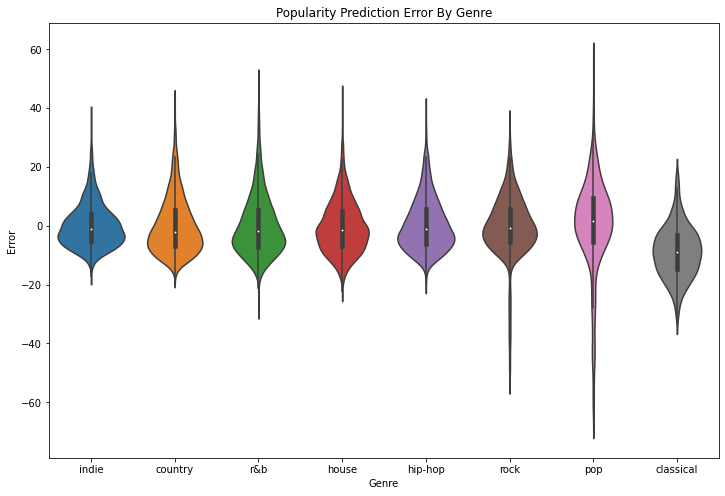

In [94]:
plt.figure(figsize=(12,8))
violin_plot = sns.violinplot(x="track_spotify_genre", y="error", data=res)

plt.xlabel('Genre')
plt.ylabel('Error') 
plt.title('Popularity Prediction Error By Genre')

plt.show(violin_plot)

Looks like it was! A few notable takeaways:
- Pop had a huge range of error. The model underpredicted error at some points by ~60, and we overpredicted the error at some points by 60. This genre was by far the most spread
- Indie seems to have performed roughly the best. The plot for that genre is thick and short, with error roughly centereda round 0 (or ~-5). 

Pop would be a great genre to focus on to improve in the future.

## This concludes my analysis for the popularity section of this project. I'm fairly satisfied with how the best model, gradient boost, performed, with a MAE of around 7.5.

## Some potential areas of improvement for this analysis would be focused around the pop genre (high range of error) and on unpopular tracks (frequent, high overprediction of the popularity of these tracks.

## If you want to see more, I chose to keep going with this project and try to predict the genre of each track given the same audible qualities. Take a look in Spotify_Analyze_Genre.ipynb notebook if you want to see more!